In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from reg_utils import sigmoid, relu, plot_decision_boundary, initialize_parameters, load_2D_dataset, predict_dec
from reg_utils import compute_cost, predict, forward_propagation, backward_propagation, update_parameters
import sklearn
import sklearn.datasets
import scipy.io
from testCases import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

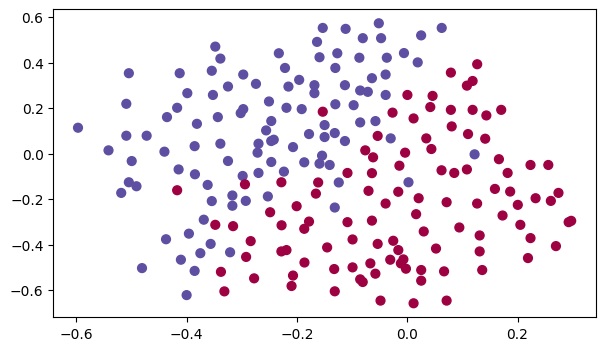

In [2]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

In [36]:
def initial_parameters(layer_dims):

    parameters = {}
    np.random.seed(3)

    #Initialise the parameters
    for i in range(1, len(layer_dims)):
        parameters['W' + str(i)] = np.random.rand(layer_dims[i], layer_dims[i - 1]) / np.sqrt(layer_dims[i-1])
        parameters['b' + str(i)] = np.zeros((layer_dims[i], 1))

    return parameters
    

In [37]:
def forward_pass(X, params):

    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']
    W3 = params['W3']
    b3 = params['b3']

    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, Z1) + b2
    A2 = relu(Z2)
    Z3 = np.dot(W3, Z2) + b3
    A3 = sigmoid(Z3)

    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3)

    return A3, cache
    
    

In [38]:
def compute_loss(a3, Y):

    m = Y.shape[1]
    
    logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
    cost = 1./m * np.nansum(logprobs)
    
    return cost

In [43]:
def compute_cost_with_regularization(a3, Y, parameters, lambd):

    m = Y.shape[1]

    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']

    lsw1 = np.sum(np.square(W1))
    lsw2 = np.sum(np.square(W2))
    lsw3 = np.sum(np.square(W3))

    cost = compute_loss(a3, Y)

    L2_reg = (lambd/(2*m)) * (lsw1 + lsw2 + lsw3)

    cost += L2_reg

    return cost
    

In [39]:
def backward_pass(X, Y, cache, params):

    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache

    gradients = {}

    m = Y.shape[1]

    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)

    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)

    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)

    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}

    return gradients

In [46]:
def backward_propagation_with_regularization(X, Y, cache, lambd):

    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache

    gradients = {}

    m = Y.shape[1]

    dZ3 = A3 - Y
    #Changing this derivative
    dW3 = 1./m * np.dot(dZ3, A2.T) + (lambd/m)*W3
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)

    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    #Changing this derivative
    dW2 = 1./m * np.dot(dZ2, A1.T) + (lambd/m)*W2
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)

    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    #Changing this derivative
    dW1 = 1./m * np.dot(dZ1, X.T) + (lambd/m)*W1
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)

    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}

    return gradients

In [40]:
def update_params(grads, learning_rate, params):

    for i in range(3):
        params['W' + str(i+1)] += grads['dW' + str(i+1)] * (-learning_rate)
        params['b' + str(i+1)] += grads['db' + str(i+1)] * (-learning_rate)

    return params
    

In [51]:
def model(X, Y, learning_rate = 0.3, num_iterations = 40000, print_cost = True, lambd = 0, keep_prob = 1):

    costs = []
    layer_dims = [X.shape[0], 20, 3, 1]
    params = initial_parameters(layer_dims)

    for _ in range(num_iterations):

        #Forward Pass
        a3, cache = forward_pass(X, params)
        # print(a3)

        #Compute Loss Function
        if lambd == 0:
            cost = compute_loss(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            

        #Backward Pass
        if lambd == 0 and keep_prob == 1:
            grads = backward_pass(X, Y, cache, params)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)

        #Update the parameters
        params = update_params(grads, learning_rate, params)

        if _ % 1000 == 0:
            print(cost)
            costs.append(cost)

    plt.plot(costs)
    plt.show()
    
    return params

/var/folders/gh/q46wdj_d4yn287xfps_6030h0000gn/T/ipykernel_72540/3724333833.py:5: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
/var/folders/gh/q46wdj_d4yn287xfps_6030h0000gn/T/ipykernel_72540/3724333833.py:5: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)


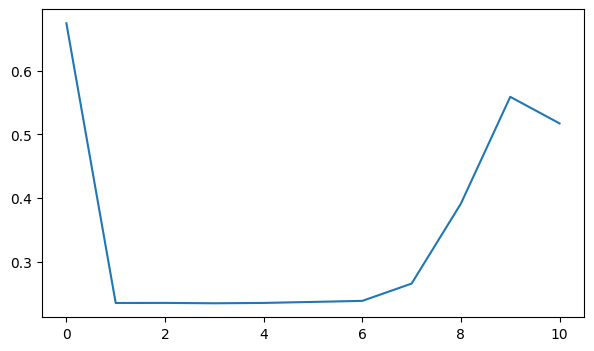

On the training set:
Accuracy: 0.5023696682464455
On the test set:
Accuracy: 0.435


In [42]:
parameters = model(train_X, train_Y)
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

In [26]:
def predict_dec(parameters, X):
    """
    Used for plotting the decision boundary.
    Arguments:
    parameters -- python dictionary containing the trained parameters
    X -- input data of size (n_features, n_samples)

    Returns:
    predictions -- vector of predictions of our model (0 or 1)
    """
    # Forward pass (get the output of the model for the input X)
    a3, _ = forward_pass(X, parameters)
    
    # Make predictions: 1 if a3 > 0.5, else 0
    predictions = (a3 > 0.5)
    
    return predictions

In [27]:
def plot_decision_boundary(model, X, y):
    # Set min and max values for X axis and Y axis (plus padding for visibility)
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01  # step size for grid

    # Create a grid of points covering the 2D space
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
                         
    # Flatten the grid so it can be input to the model (it's just a matrix of 2D points)
    grid_points = np.c_[xx.ravel(), yy.ravel()].T

    # Use the trained model to predict classes for each point in the grid
    Z = model(grid_points)  # model here is the function predict_dec with parameters

    # Reshape the predictions to match the shape of the grid
    Z = Z.reshape(xx.shape)

    # Plot the contour map (decision boundary)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)

    # Also scatter-plot the original data points
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.title("Decision Boundary")
    plt.show()


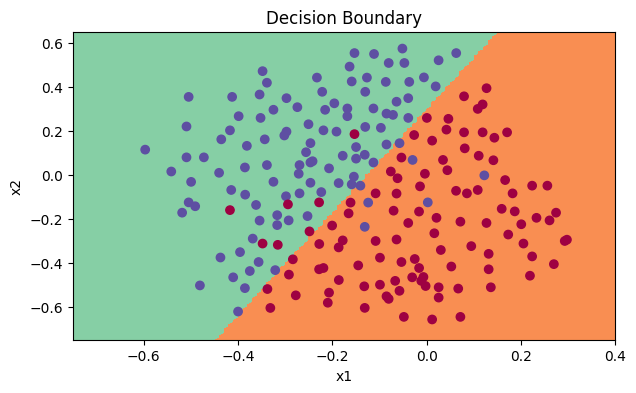

In [28]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])

# Define the prediction function for the decision boundary
decision_boundary_model = lambda x: predict_dec(parameters, x)

# Plot the decision boundary using the trained model
plot_decision_boundary(decision_boundary_model, train_X, train_Y)


# With L2 Regularisation

Before diving into L1 regularisation, let's take a look at L1 regularisation.
At the core of L1 regularization, also known as Lasso (Least Absolute Shrinkage and Selection Operator), is a simple yet powerful modification to the loss function used in a machine learning model. The standard loss function, which measures the difference between the predicted and actual values, is augmented by adding a penalty term.

    Lossl1 = Loss(ori) - lambd * sum of (|W|)

Lossₒᵣᵢ represents the original loss function (like mean squared error in linear regression), λ is a hyperparameter that determines the strength of the regularization, and wi​ denotes the coefficients of the model. The inclusion of the absolute value of the coefficients as a penalty encourages the model to keep these coefficients as small as possible.

The primary consequence of L1 regularization is its tendency to drive some of the model coefficients to zero, effectively excluding certain features from the model. This phenomenon is particularly beneficial when dealing with high-dimensional data, where some features might be irrelevant or redundant. By pushing coefficients to zero, L1 regularization performs feature selection, simplifying the model and enhancing its interpretability.

L2 Regularisation - 

L2 regularization, commonly known as Ridge regression, introduces a different type of penalty to the loss function of a machine learning model compared to L1 regularization. In L2 regularization, the penalty term is the sum of the squares of the model coefficients. This is mathematically represented as:

The primary effect of L2 regularization is to shrink the coefficients towards zero, but unlike L1 regularization, it does not set them to zero. This shrinkage helps in reducing model complexity and preventing overfitting, particularly in situations where the dataset has highly correlated features.

In [44]:
A3, Y_assess, parameters = compute_cost_with_regularization_test_case()

print("cost = " + str(compute_cost_with_regularization(A3, Y_assess, parameters, lambd = 0.1)))

cost = 1.7864859451590758


In [47]:
#Testing the new Backpropagation
X_assess, Y_assess, cache = backward_propagation_with_regularization_test_case()

grads = backward_propagation_with_regularization(X_assess, Y_assess, cache, lambd = 0.7)
print ("dW1 = \n"+ str(grads["dW1"]))
print ("dW2 = \n"+ str(grads["dW2"]))
print ("dW3 = \n"+ str(grads["dW3"]))

dW1 = 
[[-0.25604646  0.12298827 -0.28297129]
 [-0.17706303  0.34536094 -0.4410571 ]]
dW2 = 
[[ 0.79276486  0.85133918]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]
dW3 = 
[[-1.77691347 -0.11832879 -0.09397446]]


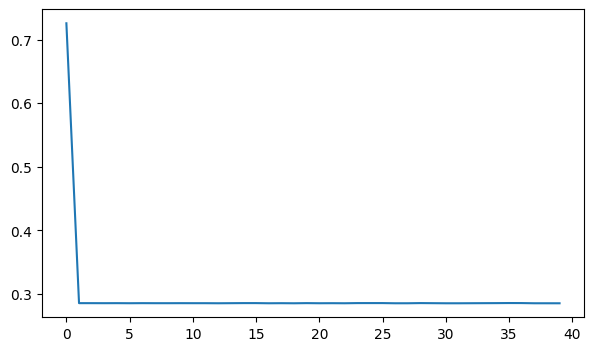

On the train set:
Accuracy: 0.8862559241706162
On the test set:
Accuracy: 0.895


In [50]:
parameters = model(train_X, train_Y, lambd = 0.7)
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

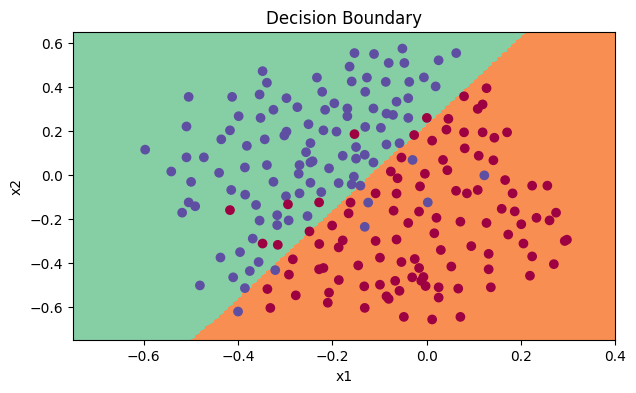

In [53]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])

decision_boundary_model = lambda x: predict_dec(parameters, x)

plot_decision_boundary(decision_boundary_model, train_X, train_Y)